# Q1

## getting the data

In [16]:
import kagglehub
import shutil
import os

path=kagglehub.dataset_download("mohamad1dehqani/persian-spam-email")

In [315]:
import pandas as pd

raw_data=pd.read_csv('./data/emails.csv')

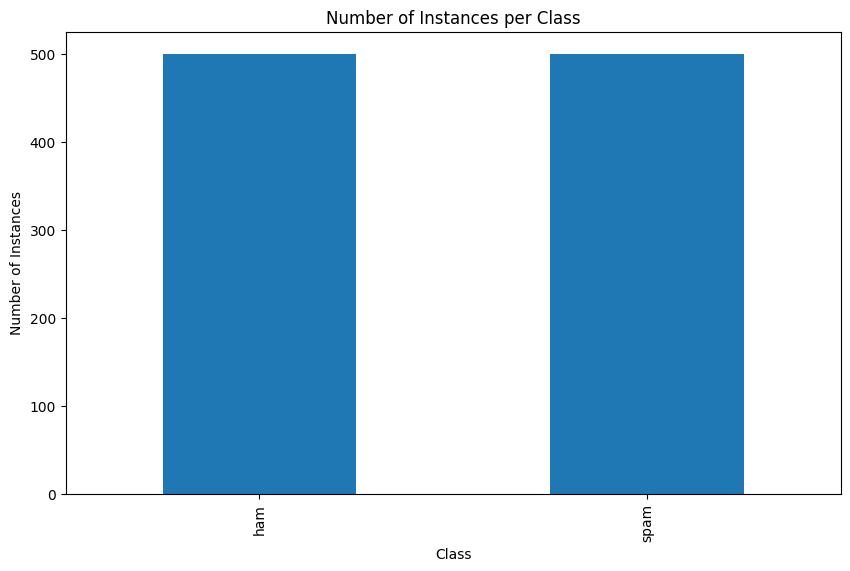

In [316]:
import matplotlib.pyplot as plt

class_counts = raw_data['label'].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Number of Instances per Class')
plt.show()


## preprocess

In [317]:
raw_data['text']

0      ﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...
1      ﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...
2      ﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...
3      ﻿با سلام  و احترام\nضمن تقدیر از مسولین محترم ...
4      ﻿با سلام اینجانب یک دستگاه خودرو پراید 131 با ...
                             ...                        
995    ﻿\nبسمه تعالی\n\nسازمان زیباسازی شهرداری استان...
996    ﻿\n\nبه مناسبت فرا رسیدن میلاد دخت پیامبر گرام...
997    ﻿\nدرود هموطن من\n\n \n\nتست رایگان   \n\n    ...
998    ﻿\n\n    *درج **لینک  در 8700 وبلاگ\n    *\n\n...
999    ﻿\nسلام به دوستان عزیز\nشما هم میتوانید از این...
Name: text, Length: 1000, dtype: object

In [318]:
import pandas as pd
import re

url_pattern = r'http[s]?://\S+|www\.\S+|WWW\.\S+|Www\.\S+|WwW\.\S+'
email_pattern = r'\b[A-Za-z0-9\*._%+-]+@[A-Za-z0-9\*.-]+\.[A-Z|a-z]{2,}\b'
phone_pattern = r'\d{11}|(\d{4}[ -\*]\d{3}[ -\*]\d{4})|\d{3}[-]+\d{8}|\d{3}[ ]+\d{8}|[(]\d{3}[) ]+\d{8}|\d{8}'
combined_pattern = f'({url_pattern})|({email_pattern})|({phone_pattern})'

def clean_text(text):
    cleaned_text = re.sub(r'(.)\1+', r'\1', text)
    return re.sub(combined_pattern, '', cleaned_text)


raw_data['text'] = raw_data['text'].apply(clean_text)

raw_data.to_csv('./data/cleaned_dataset.csv', index=False)

In [319]:
with open('./data/persian_stopwords', 'r', encoding='utf-8') as f:
    persian_stop_words = f.read().splitlines()

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in persian_stop_words]
    return ' '.join(filtered_words)

raw_data['text'] = raw_data['text'].apply(remove_stopwords)
raw_data.to_csv('./data/cleaned_dataset.csv', index=False)

## tokenizing

In [320]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

texts = raw_data['text'].tolist()
inputs = tokenizer(texts, padding='max_length', max_length=32, return_tensors="pt", truncation=True)

with torch.no_grad():
    outputs = model(**inputs)

hidden_states = outputs.last_hidden_state
sentence_vectors = hidden_states.mean(dim=1).numpy()

In [321]:
from sklearn.decomposition import PCA


pca = PCA(n_components=120)
reduced_vectors = pca.fit_transform(sentence_vectors)

vectorized_data = pd.DataFrame(reduced_vectors)

## training CNN-LSTM model

In [322]:
labels = raw_data['label'].values.copy()
for i in range(len(labels)):
    if labels[i]=='ham':
        labels[i]=0
    else:
        labels[i]=1

In [332]:
import numpy as np
sequence_length = 1
num_samples = vectorized_data.shape[0]
num_features = vectorized_data.shape[1]

num_sequences = num_samples // sequence_length

# data_reshaped = vectorized_data[:num_sequences * sequence_length].to_numpy().reshape(num_sequences, sequence_length, num_features)

labels_reshaped = labels[:num_sequences * sequence_length].reshape(num_sequences, sequence_length)
labels_reshaped = labels_reshaped[:, -1] 

print(vectorized_data.shape)
print(labels_reshaped.shape)

(1000, 120)
(1000,)


In [324]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vectorized_data, labels_reshaped, test_size=0.3, random_state=42)

In [325]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [333]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense

cnn_model = Sequential([
    Embedding(input_dim=6000, output_dim=64,embeddings_initializer='uniform'),
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(152, 64)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

cnn_model.build(input_shape=(None, 120))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()


c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_134"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_100 (Embedding)       │ (None, 120, 64)        │       384,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_103 (Conv1D)             │ (None, 118, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_105               │ (None, 59, 32)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_64 (Flatten)            │ (None, 1888)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │         1,889 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,065 (1.50 MB)

 Trainable params: 392,065 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [334]:
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_train[:len(X_train)//5], y_train[:len(y_train)//5]))

loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5129 - loss: 0.6931 - val_accuracy: 0.6714 - val_loss: 0.6850
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7071 - loss: 0.6812 - val_accuracy: 0.8857 - val_loss: 0.6591
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8465 - loss: 0.6504 - val_accuracy: 0.8857 - val_loss: 0.5873
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8640 - loss: 0.5712 - val_accuracy: 0.8857 - val_loss: 0.4520
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8748 - loss: 0.4439 - val_accuracy: 0.9143 - val_loss: 0.3295
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9011 - loss: 0.3247 - val_accuracy: 0.9143 - val_loss: 0.2519
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9282 - loss: 0.2626 - val_accuracy: 0.9429 - val_loss: 0.2034
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9260 - loss: 0.2208 - val_accuracy: 0.9571 - val_lo

In [350]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout

# lstm_model = Sequential([
#     Embedding(input_dim=6000, output_dim=64),
#     LSTM(64, dropout=0.2),
#     Dense(1, activation='sigmoid')
# ])

# lstm_model.build(input_shape=(None, 120))
# lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# lstm_model.summary()

lstm_model = Sequential([
    Embedding(input_dim=6000, output_dim=64),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()



Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_105 (Embedding)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_74 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_75 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [351]:
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.4699 - loss: 0.6946 - val_accuracy: 0.4357 - val_loss: 0.6955
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5291 - loss: 0.6926 - val_accuracy: 0.4357 - val_loss: 0.6979
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5320 - loss: 0.6916 - val_accuracy: 0.4357 - val_loss: 0.6956
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4977 - loss: 0.6934 - val_accuracy: 0.4357 - val_loss: 0.6968
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5218 - loss: 0.6926 - val_accuracy: 0.4357 - val_loss: 0.6977
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5237 - loss: 0.6925 - val_accuracy: 0.4357 - val_loss: 0.6951
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5637 - loss: 0.6918 - val_accuracy: 0.4357 - val_loss: 0.6967
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5038 - loss: 0.6935 - val_accuracy: 0.4357 - v

In [337]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, LSTM

cnn_lstm_model = Sequential([
    Embedding(input_dim=6000, output_dim=64,embeddings_initializer='uniform'),
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(152, 64)),
    MaxPooling1D(pool_size=2),
    LSTM(64, dropout=0.2),
    Dense(1, activation='sigmoid')
])

cnn_lstm_model.build(input_shape=(None, 120))
cnn_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_lstm_model.summary()

c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_102 (Embedding)       │ (None, 120, 64)        │       384,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_104 (Conv1D)             │ (None, 118, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_106               │ (None, 59, 32)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_71 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,073 (1.58 MB)

 Trainable params: 415,073 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [339]:
cnn_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_train[:len(X_train)//5], y_train[:len(y_train)//5]))

loss, accuracy = cnn_lstm_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8453 - loss: 0.3378 - val_accuracy: 0.9286 - val_loss: 0.2090
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9298 - loss: 0.2051 - val_accuracy: 0.9357 - val_loss: 0.1642
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9385 - loss: 0.1797 - val_accuracy: 0.9571 - val_loss: 0.1437
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9528 - loss: 0.1626 - val_accuracy: 0.9643 - val_loss: 0.1222
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9573 - loss: 0.1336 - val_accuracy: 0.9500 - val_loss: 0.1422
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9581 - loss: 0.1408 - val_accuracy: 0.9643 - val_loss: 0.1399
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9384 - loss: 0.1723 - val_accuracy: 0.9500 - val_loss: 0.1977
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9486 - loss: 0.1627 - val_accuracy: 0.9571 - v

## Eval: